In [1]:
import numpy as np
from sklearn.datasets import make_moons
import pandas as pd
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
moons = make_moons(n_samples=1000, random_state=42)

In [4]:
X = moons[0]
y= moons[1]

In [5]:
feature_names = ['feature_'+str(i) for i in range(X.shape[1])]
# feature_names

In [6]:
moons_df = pd.DataFrame(X, columns = feature_names)
moons_df['class'] = y

In [8]:
moons_df.head()

,feature_0,feature_1,class
0,0.008727,0.368174,1
1,0.921384,-0.496905,1
2,0.940226,-0.498212,1
3,0.465875,-0.345406,1
4,-0.850412,0.526117,0


In [15]:
moons_df['class'].value_counts()

1    500
0    500
Name: class, dtype: int64

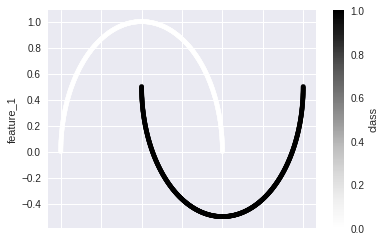

In [14]:
moons_df.plot.scatter(x='feature_0', y='feature_1', c='class')

In [18]:
start = X[np.random.choice(X.shape[0])]

In [19]:
start

array([ 1.93849061,  0.15469524])

In [72]:
all_dists = cdist(X, X[0])
r = dists.mean() * 0.1

ValueError: XB must be a 2-dimensional array.

In [48]:
cluster_1 = X[:3]
working_dist = cdist(X, cluster_1)

In [51]:
working_cluster = working_dist.min(axis=1) < r

In [55]:
np.array_equal(cluster_1, cluster_1)

True

In [105]:
class DBScanScratch:
    def __init__(self):
        self.r = None
        self.cluster_labels = None
        self.assigned_clusters = None

    
    def fit(self, X):
        all_dists = cdist(X, X)
        self.r = dists.mean() * 0.1 # set radius for dbscan search. make this a tunable parameter
        
        # set all observations in X to cluster == 0, i.e. unclustered
        self.assigned_clusters = np.zeros(X.shape[0])
                        
        current_cluster = 1 # start with cluster 1
        
        while np.any(self.assigned_clusters == 0): # while unclustered entries exist
            print("working on cluster", current_cluster)
            
            # pick a random starting point
            X_unclustered = X[self.assigned_clusters == 0]
            starting_point = X_unclustered[np.random.choice(X_unclustered.shape[0])] 
            
            #cdist function needs starting_point to be 2d; this is a hacky work around
            starting_point = np.array([starting_point, starting_point])
            
            bool_cluster = self.scan(X, starting_point)
            self.assigned_clusters += bool_cluster * current_cluster
            
            current_cluster += 1 # increment current cluster
            
        self.cluster_labels = np.array(set(self.assigned_clusters))
    
    def scan(self, X, working_cluster):
        print(working_cluster.shape)
        scan_dist = cdist(X, working_cluster) #measure distance between all X observation and clustered observations
        closest_scan = scan_dist.min(axis=1) # get shortest measured distance
        within_scan = closest_scan <= self.r # bool array of observations of X who are within r, i.e the cluster
        
        updated_working_cluster = X[within_scan]
        
        if not np.array_equal(working_cluster, updated_working_cluster):
            within_scan = np.add(within_scan, self.scan(X, updated_working_cluster))
            
        return within_scan


In [106]:
dbs_scratch = DBScanScratch()

In [107]:
dbs_scratch.fit(X)

working on cluster 1
(2, 2)
(39, 2)
(77, 2)
(115, 2)
(153, 2)
(191, 2)
(229, 2)
(267, 2)
(303, 2)
(322, 2)
(341, 2)
(360, 2)
(379, 2)
(398, 2)
(417, 2)
(436, 2)
(455, 2)
(474, 2)
(493, 2)
(500, 2)
working on cluster 2
(2, 2)
(39, 2)
(77, 2)
(115, 2)
(151, 2)
(170, 2)
(189, 2)
(208, 2)
(227, 2)
(246, 2)
(265, 2)
(284, 2)
(303, 2)
(322, 2)
(341, 2)
(360, 2)
(379, 2)
(398, 2)
(417, 2)
(436, 2)
(455, 2)
(474, 2)
(493, 2)
(500, 2)


In [109]:
moons_df['assigned'] = dbs_scratch.assigned_clusters

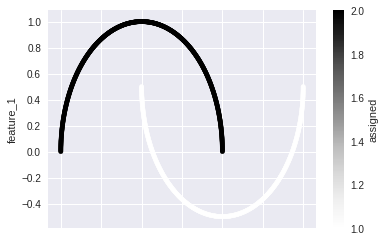

In [110]:
moons_df.plot.scatter(x='feature_0', y='feature_1', c='assigned')